# ARIMA and LSTM Time Series Models

In this project, I will perform both Autoregressive Integrated Moving Average (ARIMA) and Long Short-Term Memory (LSTM) models to predict stock prices. 

### Introduction
In this notebook, we will perform time series analysis and forecasting and will utilize pandas and numpy for datetime as well as using statsmodel and keras for ARIMA and LSTM models, respectively. At the begining of ARIMA model, we always check for the state of stationarity of the dataset. If it was not stationary, we will conduct a log-transformation to remove the variation part. The trend part could be removed too by differencing. 

#### Introduction to the datasets:
We apply the ARIMA models to three sets of data all related to stock data analysis. The first example includes stock time series for Amazon, Google, Apple, and Microsoft. The second example is time series analysis for S&P500 stock data. The last example is for CAC40 Stocks. 
  


### Executive Summary 
- The ARIMA and LSTM models were implemented on three stock datasets.
- The datasets were tested for stationarity.
- The optimum values for p, d, and q were obtained by iterating through multiple values of these parameters, evaluating the model for each set of parameters and then find the best sets of values.
- The ARIMA model gave lower root mean squared errors (RMSEs) in 2/3 of the studied time series compared to the LSTM model. In many cases, the models gave similar errors, but on the whole, ARIMA provided higher-quality results, though it struggled to converge on a few series.


# Import Packages

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.ndimage.filters import gaussian_filter
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# ARIMA Model

The function below creates an ARIMA model rolling forecast for a given input time series. It allows the user to select p, q, and d values, as well as specify whether to log transform (or not). The various steps in the function include:

1. log transforming data
2. creating train/test splits
3. creating an ARIMA model for the train set
4. forecasting the first value in the test set, followed by adding that value to the training set and remodeling, forecasting the next value in the test series, adding that second value to the train set, and so on.
5. inverse transforming the data
6. creating plots and generating error metrics.

This function will be used below with tuning of the p, d, q, and log transform parameters in order to minimize RMSE values for the out-of-sample data associated with various time series.

In [2]:
#import statsmodels.api as smapi
def evaluate_arima_model(data, arima_order):
    '''
    This function generates ARIMA model 

    '''
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test= data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()
        predictions.append(future[0])
        past.append(test.values[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

In [3]:
def arima_params(df, p_max, d_max, q_max):
    '''
    This function will iterate over the p, d, and q
    calls the evaluate ARIMA model and find the best
    sets of parameters for p, d, q
    '''
    best_score, best_cfg = float("inf"), None
    for p in range(p_max):
        for d in range(d_max):
            for q in range(q_max):
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(df, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    return best_score, best_cfg

In [4]:
import matplotlib.dates as mdates

def arima_model(series, data_split, params, future_periods, log):
    '''
    This function uses the parameters that were optimized using the previous two functions
    and then split the data into training and test as well as performing ARIMA model and evaluate
    the predited results using RMSE.
    '''
    # log transformation of data if user selects log as true
    if log == True:
        series_dates = series.index
        series = pd.Series(np.log(series), index=series.index)
       
    # create training and testing data sets based on user split fraction
    size = int(len(series) * data_split)
    train, test = series[0:size], series[size:len(series)]
    history = [val for val in train]
    predictions = []

    # creates a rolling forecast by testing one value from the test set, and then add that test value
    # to the model training, followed by testing the next test value in the series
    for t in range(len(test)):
        model = ARIMA(history, order=(params[0], params[1], params[2]))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    
    # forecasts future periods past the input testing series based on user input
    future_forecast = model_fit.forecast(future_periods)
    future_dates = [test.index[-1]+timedelta(i*365/12) for i in range(1, future_periods+1)]
    test_dates = test.index
    
    # if the data was originally log transformed, the inverse transformation is performed
    if log == True:
        predictions = np.exp(predictions)
        test = pd.Series(np.exp(test), index=test_dates)
        future_forecast = np.exp(future_forecast)
    
    # creates pandas series with datetime index for the predictions and forecast values
    forecast = pd.Series(future_forecast, index=future_dates)
    predictions = pd.Series(predictions, index=test_dates)
    
    # generates plots to compare the predictions for out-of-sample data to the actual test values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #myFmt = mdates.DateFormatter('%m%/%y')
    #ax.xaxis.set_major_formatter(myFmt)
    plt.plot(predictions, c='red')
    plt.plot(test)
    plt.plot(forecast)
    plt.show()
    
    # calculates root mean squared errors (RMSEs) for the out-of-sample predictions
    error = np.sqrt(mean_squared_error(predictions, test))
    print('Test RMSE: %.3f' % error)
    
    return error, predictions, test, future_forecast, future_dates

# LSTM Neural Network Model

The LSTM calculations use three different functions for creating a dataset that can be modeled, training and testing the LSTM neural network, and then inverting any data transformations so that data can be plotted and error analyzed on the original scale. Each function is described in more detail below.

### Creating the datset

This function is used to create the datsets required for training and testing LSTM neural nets. It accepts a time series, the number of previous periods the user would like to model, the train / test split fractions, and whether to perform differencing or log transforms on the data to make it stationary. It will also scale all data between 0 and 1 for input into the LSTM.

The features to be trained are essentially t-n time periods. So if modeling data for the current month (t-0), the input feature would be the data for the previous month (t-1), while the target would be the actual value for this current month (assuming it's known). Increasing look_back will add additional previous months to include, e.g. two months ago (t-2) and three months ago (t-3).

In [5]:
def create_dataset(data_series, look_back, split_frac, transforms):
    
    # log transforming that data, if necessary
    if transforms[0] == True:
        dates = data_series.index
        data_series = pd.Series(np.log(data_series), index=dates)
    
    # differencing data, if necessary
    if transforms[1] == True:
        dates = data_series.index
        data_series = pd.Series(data_series - data_series.shift(1), index=dates).dropna()

    # scaling values between 0 and 1
    dates = data_series.index
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_series.values.reshape(-1, 1))
    data_series = pd.Series(scaled_data[:, 0], index=dates)
    
    # creating targets and features by shifting values by 'i' number of time periods
    df = pd.DataFrame()
    for i in range(look_back+1):
        label = ''.join(['t-', str(i)])
        df[label] = data_series.shift(i)
    df = df.dropna()
    print(df.tail())
    
    # splitting data into train and test sets
    size = int(split_frac*df.shape[0])
    train = df[:size]
    test = df[size:]
    
    # creating target and features for training set
    X_train = train.iloc[:, 1:].values
    y_train = train.iloc[:, 0].values
    train_dates = train.index
    
    # creating target and features for test set
    X_test = test.iloc[:, 1:].values
    y_test = test.iloc[:, 0].values
    test_dates = test.index
    
    # reshaping data into 3 dimensions for modeling with the LSTM neural net
    X_train = np.reshape(X_train, (X_train.shape[0], 1, look_back))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, look_back))
    
    return X_train, y_train, X_test, y_test, train_dates, test_dates, scaler

### Inverse transformations

This inverse transform function simply reverses any transformations performed when generating the dataset. Inversing the transformations allows for the model predictions to be based on the same scale as the original dataset for more intuitive interpretation of results. Both the model creation and inverse transformation functions are automatically called within the LSTM function below.

In [6]:
def inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler):
    
    # inverse 0 to 1 scaling
    train_predict = pd.Series(scaler.inverse_transform(train_predict.reshape(-1,1))[:,0], index=train_dates)
    y_train = pd.Series(scaler.inverse_transform(y_train.reshape(-1, 1))[:,0], index=train_dates)

    test_predict = pd.Series(scaler.inverse_transform(test_predict.reshape(-1, 1))[:,0], index=test_dates)
    y_test = pd.Series(scaler.inverse_transform(y_test.reshape(-1, 1))[:,0], index=test_dates)
    
    # reversing differencing if log transformed as well
    if (transforms[1] == True) & (transforms[0] == True):
        train_predict = pd.Series(train_predict + np.log(data_series.shift(1)), index=train_dates).dropna()
        y_train = pd.Series(y_train + np.log(data_series.shift(1)), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + np.log(data_series.shift(1)), index=test_dates).dropna()
        y_test = pd.Series(y_test + np.log(data_series.shift(1)), index=test_dates).dropna()
    
    # reversing differencing if no log transform
    elif transforms[1] == True:
        train_predict = pd.Series(train_predict + data_series.shift(1), index=train_dates).dropna()
        y_train = pd.Series(y_train + data_series.shift(1), index=train_dates).dropna()

        test_predict = pd.Series(test_predict + data_series.shift(1), index=test_dates).dropna()
        y_test = pd.Series(y_test + data_series.shift(1), index=test_dates).dropna()
      
    # reversing log transformation
    if transforms[0] == True:
        train_predict = pd.Series(np.exp(train_predict), index=train_dates)
        y_train = pd.Series(np.exp(y_train), index=train_dates)

        test_predict = pd.Series(np.exp(test_predict), index=test_dates)
        y_test = pd.Series(np.exp(y_test), index=test_dates)
        
    return train_predict, y_train, test_predict, y_test

### LSTM modeling

Calling the LSTM model below only requires a time series dataset, the number of desired look-back periods, the train/test split, whether to log transform or difference the data, and parameters for training such as number of nodes and epochs. Within the function, it creates the train and test datasets—both features and targets—and then trains an LSTM model, followed by forecasting the out-of-sample data. The predictions from the model, as well as the actual target values are then inverse transformed using the function above, and plots are generated along with error metrics.

In [7]:
def lstm_model(data_series, look_back, split, transforms, lstm_params):
    np.random.seed(1)
    
    # creating the training and testing datasets
    X_train, y_train, X_test, y_test, train_dates, test_dates, scaler = create_dataset(data_series, look_back, split, transforms)
    X_train_r, y_train_r, X_test_r, y_test_r, train_dates_r, test_dates_r, scaler_r = create_dataset(data_series, look_back, split, transforms)
    # training the model
    model = Sequential()
    model.add(LSTM(lstm_params[0], input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=lstm_params[1], batch_size=1, verbose=lstm_params[2])
    
    # making predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # inverse transforming results
    train_predict, y_train, test_predict, y_test = \
    inverse_transforms(train_predict, y_train, test_predict, y_test, data_series, train_dates, test_dates, scaler)
    
    # plot of predictions and actual values
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #myFmt = mdates.DateFormatter('%m%/%y')
    #ax.xaxis.set_major_formatter(myFmt)
    plt.plot(y_test)
    plt.plot(test_predict, color='red')
    plt.show()
    
    # calculating RMSE metrics
    error = np.sqrt(mean_squared_error(train_predict, y_train))
    print('Train RMSE: %.3f' % error)
    error = np.sqrt(mean_squared_error(test_predict, y_test))
    print('Test RMSE: %.3f' % error)
    
    return error, train_predict, y_train, test_predict, y_test, X_train_r, y_train_r, X_test_r, y_test_r, train_dates_r, test_dates_r, scaler_r 

# Examples of Various Time Series
 In this section, we use different time series data to predict stock price changes. The first example is from Yahoo Finances. The second example includes ARIMA and LSTM modeling for S&P 500 historical data and the last example includes predictive modeling for CAC40 Stocks.

In general, I optimized p, d, q and log transformation values for ARIMA models, and log/differencing and epochs for LSTM models. 

For each example, the plots show the out-of-sample predictions with the actual test values, along with RMSE values. For all plots, the actual (or filtered) time series is traced in BLUE, while the predictions are traced in RED. 

### Example 1: Yahoo Finances

In [132]:
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
    
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
#!pip install yfinance
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
# For time stamps
import datetime

In [135]:
# Stock data downloading
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.datetime.now()
start = datetime.datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0) # concatenate the list of dataframes
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-03-04,177.529999,180.139999,177.490005,177.580002,177.580002,37381500,AMAZON
2024-03-05,176.929993,176.929993,173.300003,174.119995,174.119995,37228300,AMAZON
2024-03-06,175.539993,176.460007,173.259995,173.509995,173.509995,32090900,AMAZON
2024-03-07,174.830002,177.990005,173.720001,176.820007,176.820007,34063300,AMAZON
2024-03-08,176.440002,178.789993,174.330002,175.350006,175.350006,37853500,AMAZON
2024-03-11,174.309998,174.470001,171.470001,171.960007,171.960007,28484800,AMAZON
2024-03-12,173.500000,176.759995,171.979996,175.389999,175.389999,36610600,AMAZON
2024-03-13,175.899994,177.619995,175.550003,176.559998,176.559998,30772600,AMAZON
2024-03-14,177.690002,179.529999,176.470001,178.750000,178.750000,43705800,AMAZON


In [182]:
type(AAPL)

pandas.core.frame.DataFrame

In [137]:
df.shape

(1008, 7)

In [138]:
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,180.100239,181.566270,178.781984,180.284762,179.792270,5.757445e+07
std,10.335482,10.165879,10.247536,10.158716,10.269515,1.722444e+07
min,152.160004,156.460007,151.639999,155.000000,154.177048,2.404830e+07
25%,172.985001,174.172504,171.645004,173.172497,172.645977,4.678918e+07
50%,180.379997,182.079994,178.440002,180.640007,180.048981,5.340815e+07
75%,189.277496,189.990005,187.652500,189.317501,188.879906,6.392830e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.366826e+08


In [139]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-03-16 to 2024-03-15
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          252 non-null    float64
 1   High          252 non-null    float64
 2   Low           252 non-null    float64
 3   Close         252 non-null    float64
 4   Adj Close     252 non-null    float64
 5   Volume        252 non-null    int64  
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


### Data Wrangling, Exploratory Data Analysis and Visualization

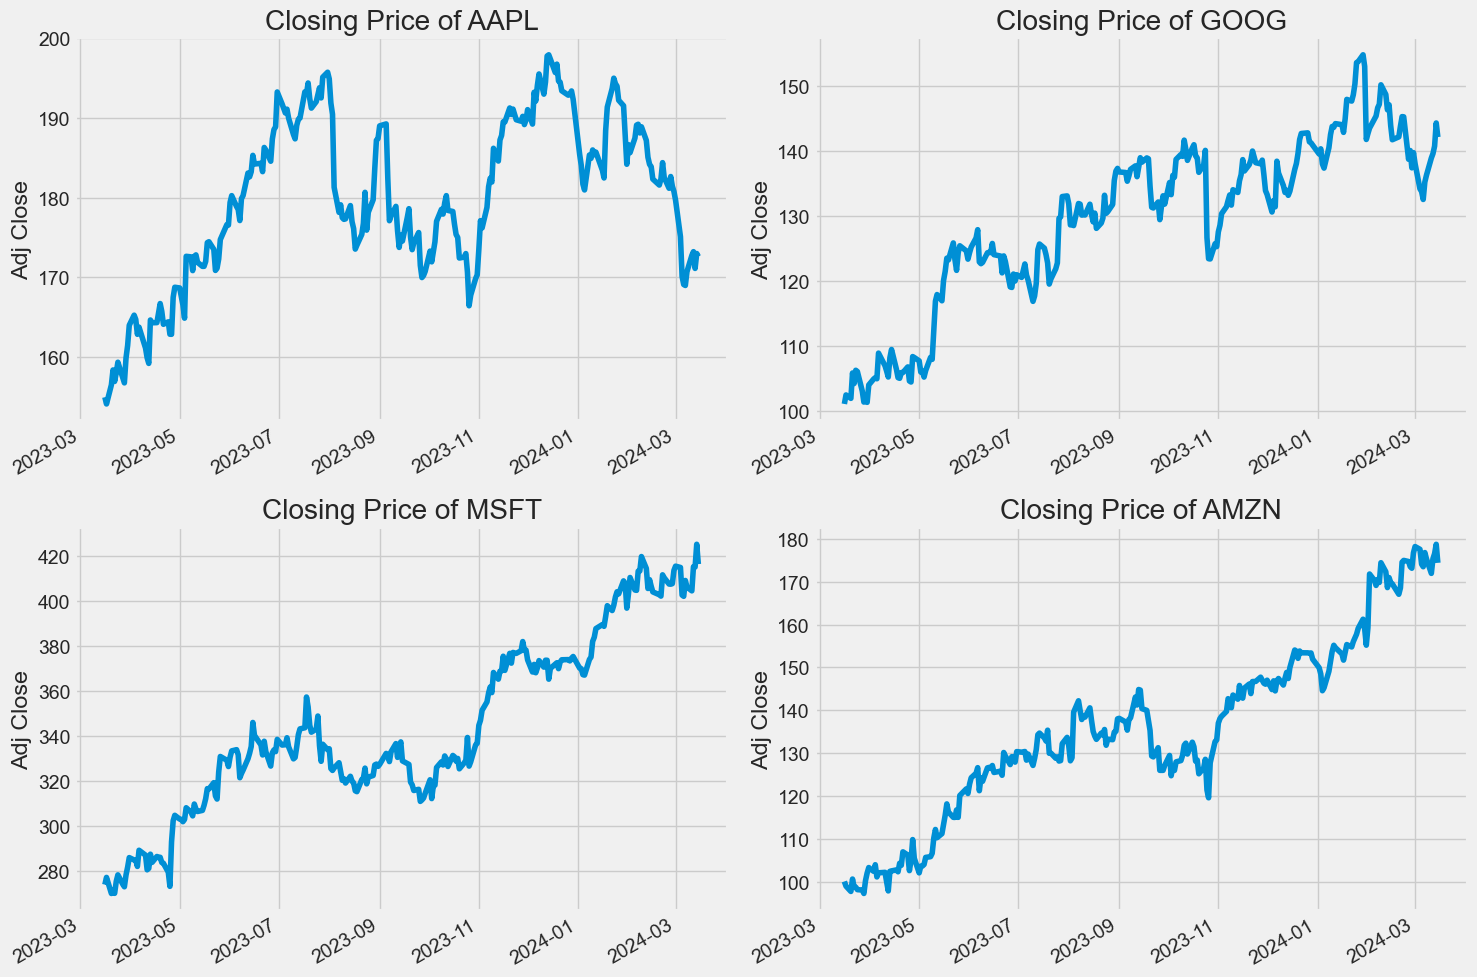

In [140]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

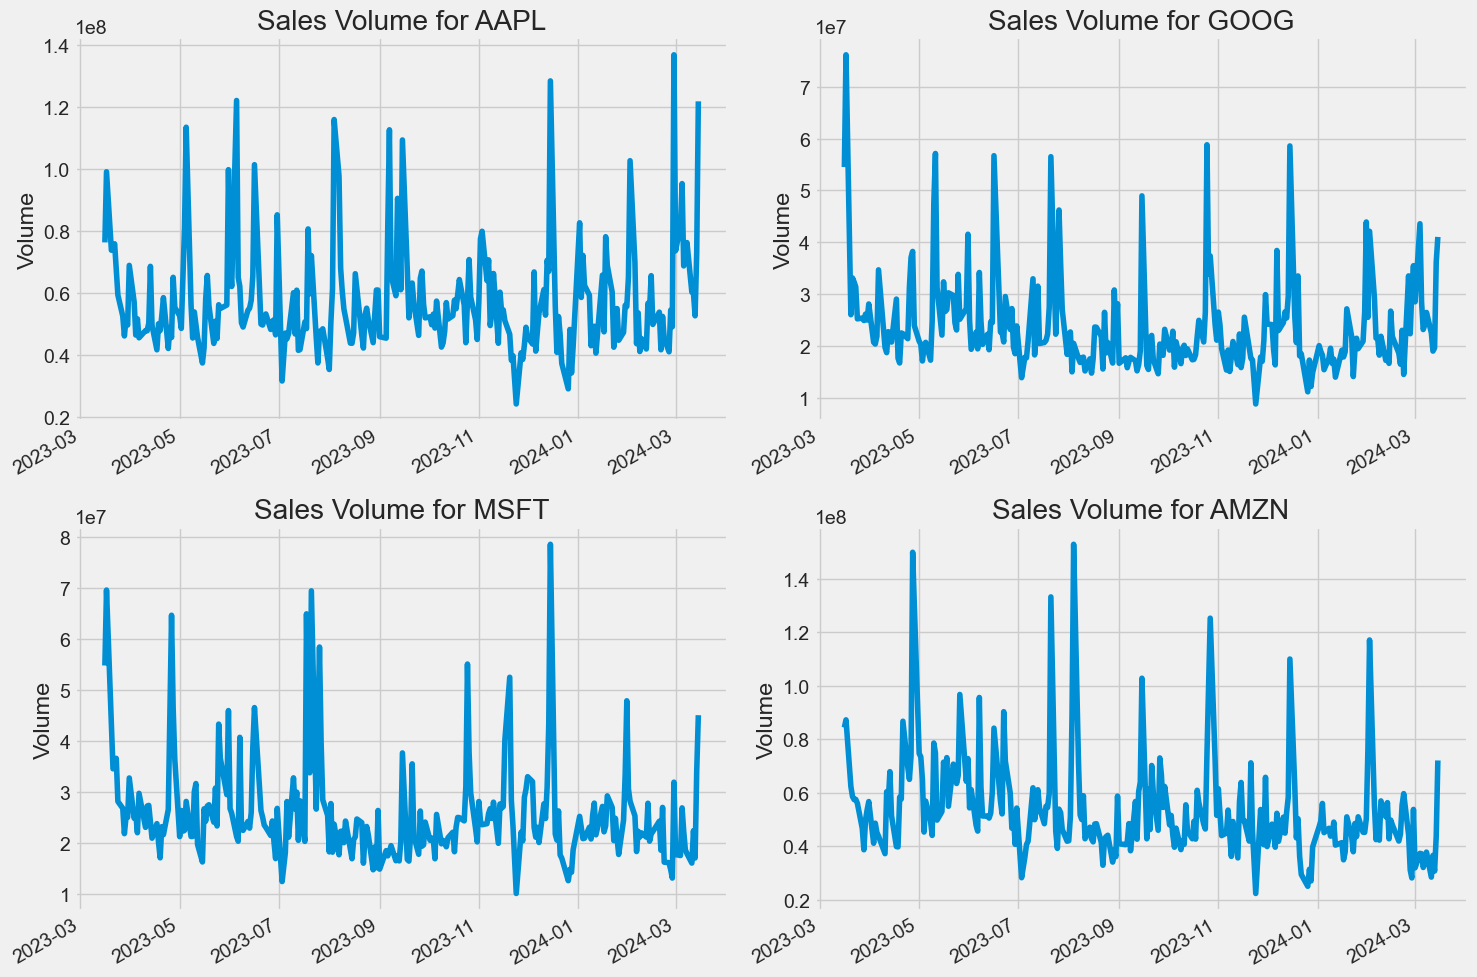

In [141]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

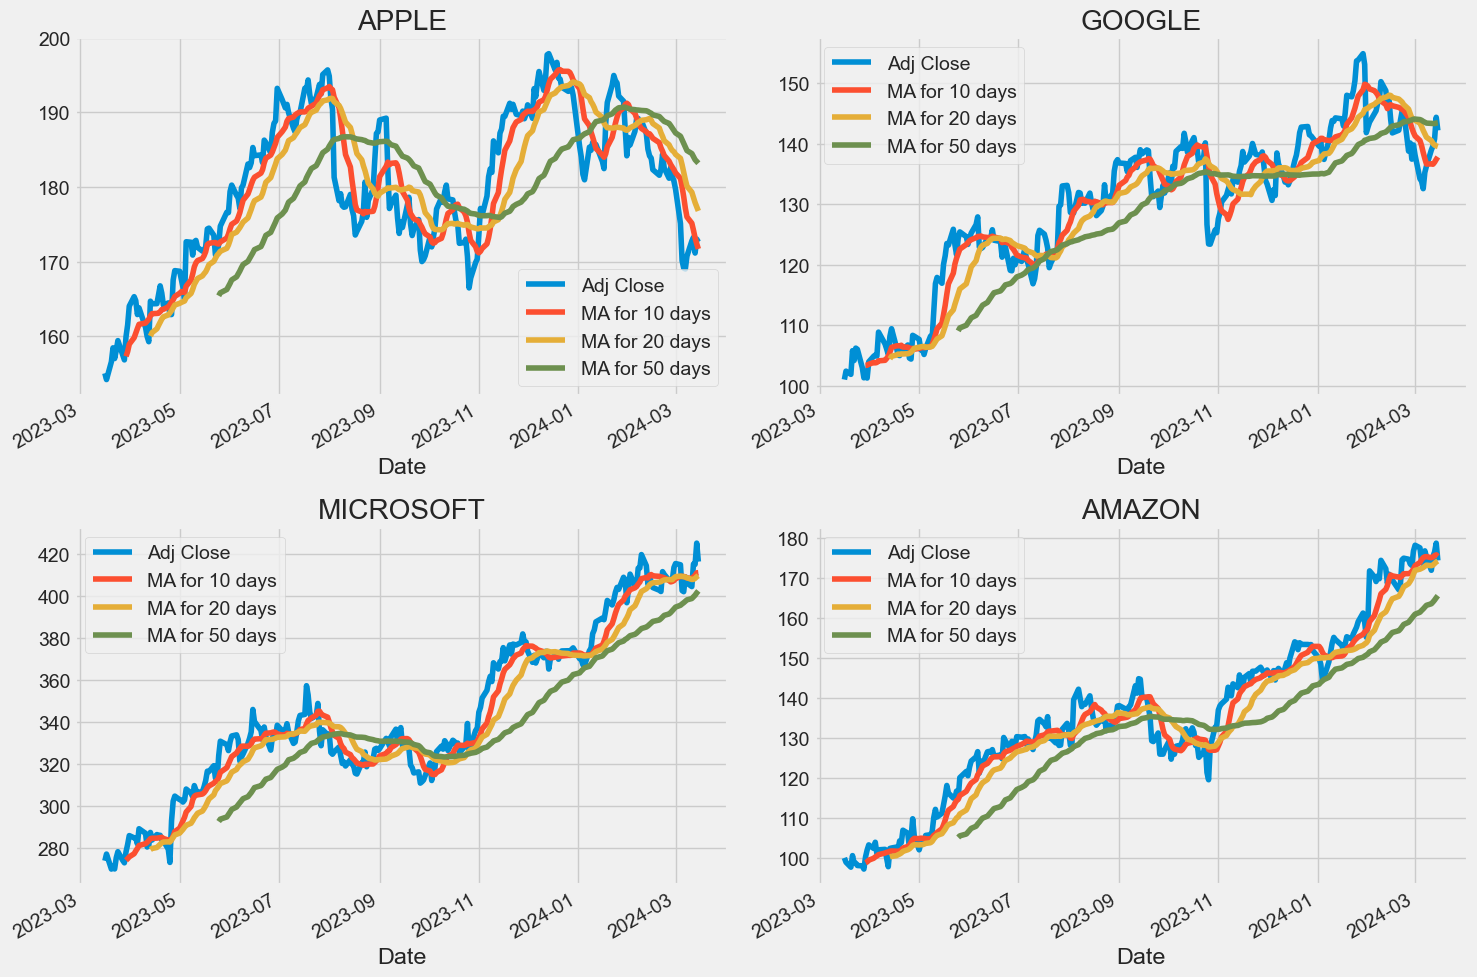

In [142]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')
fig.tight_layout()

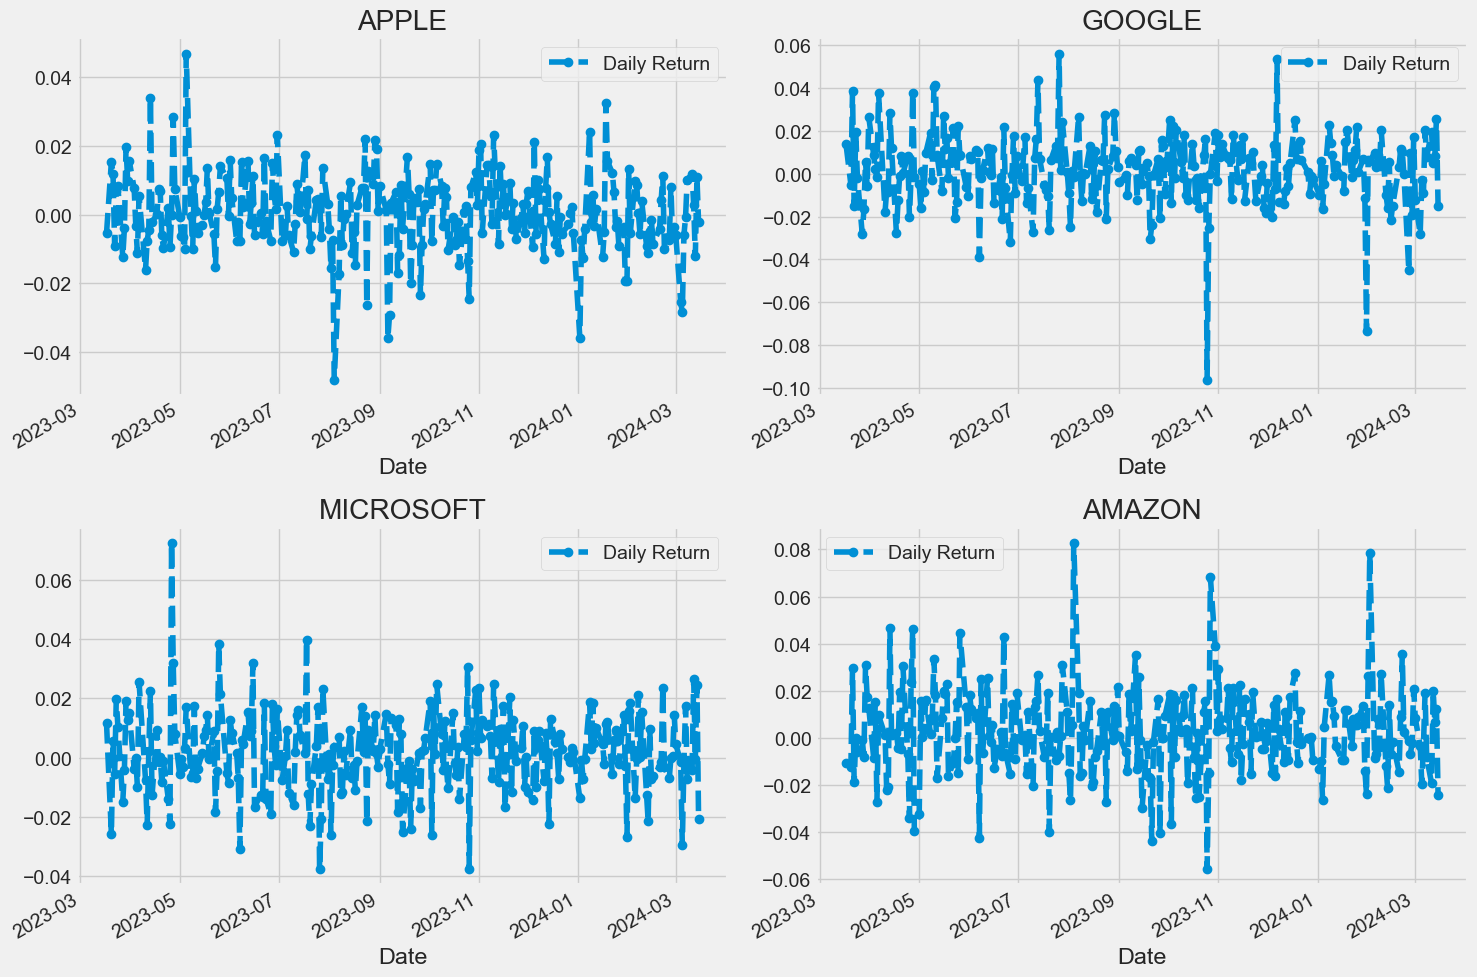

In [143]:
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')
fig.tight_layout()

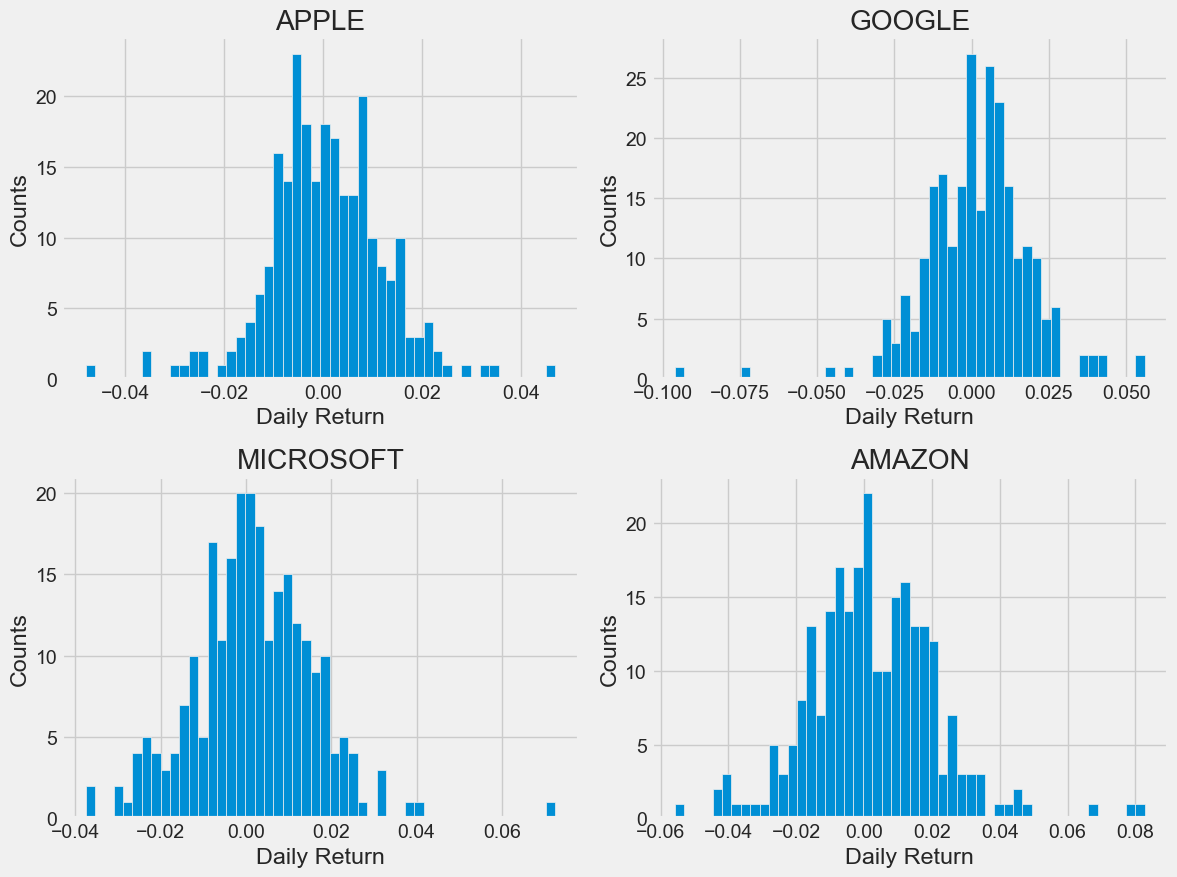

In [144]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()

In [145]:
closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-03-16,NaN,NaN,NaN,NaN
2023-03-17,-0.005454,-0.010896,0.013753,0.011694
2023-03-20,0.015484,-0.012532,-0.005173,-0.025767
2023-03-21,0.011944,0.029680,0.038360,0.005694
2023-03-22,-0.009103,-0.018984,-0.015306,-0.005442


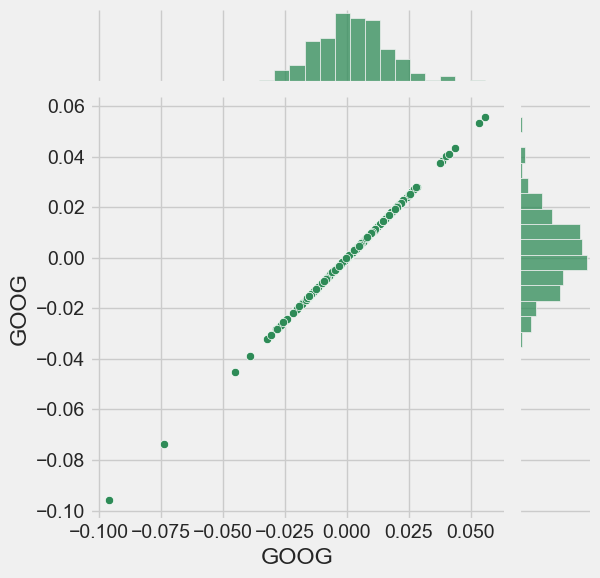

In [146]:
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

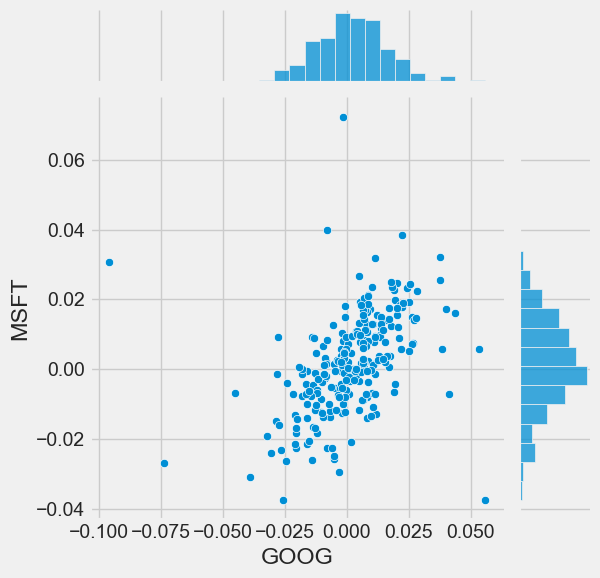

In [147]:
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

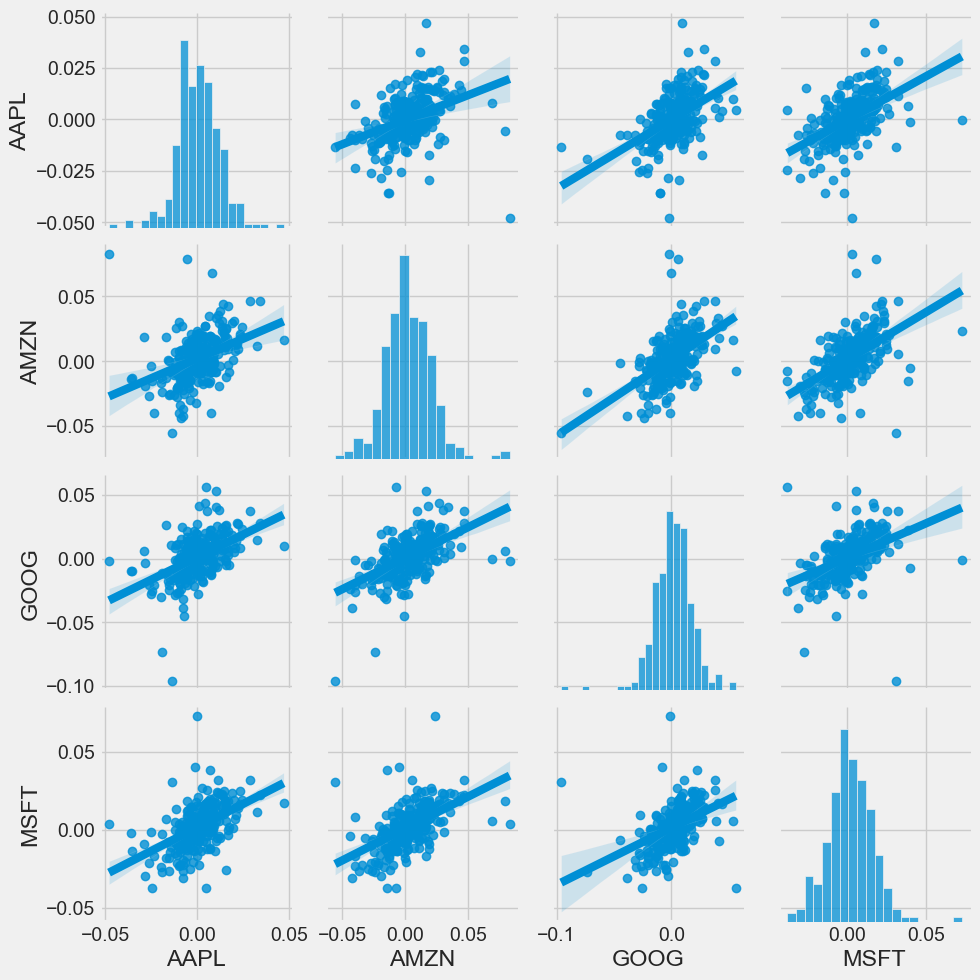

In [148]:
sns.pairplot(tech_rets, kind='reg')

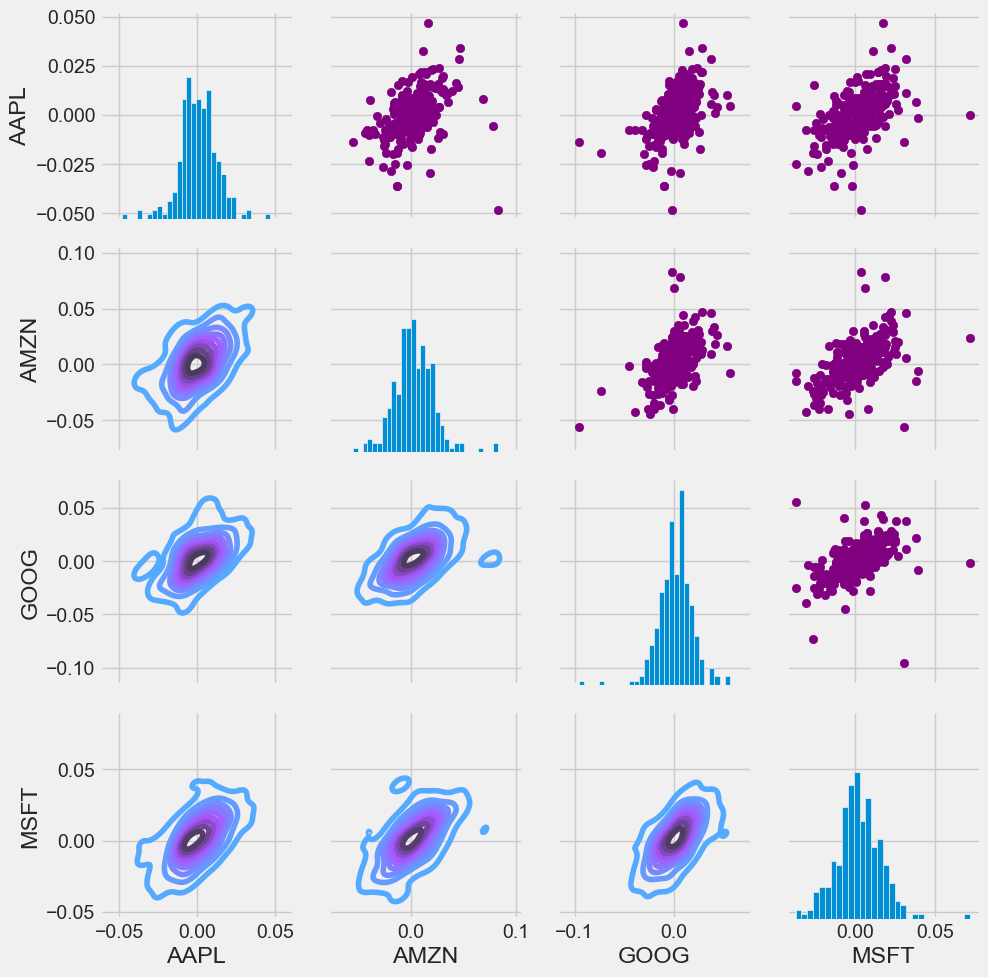

In [149]:
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

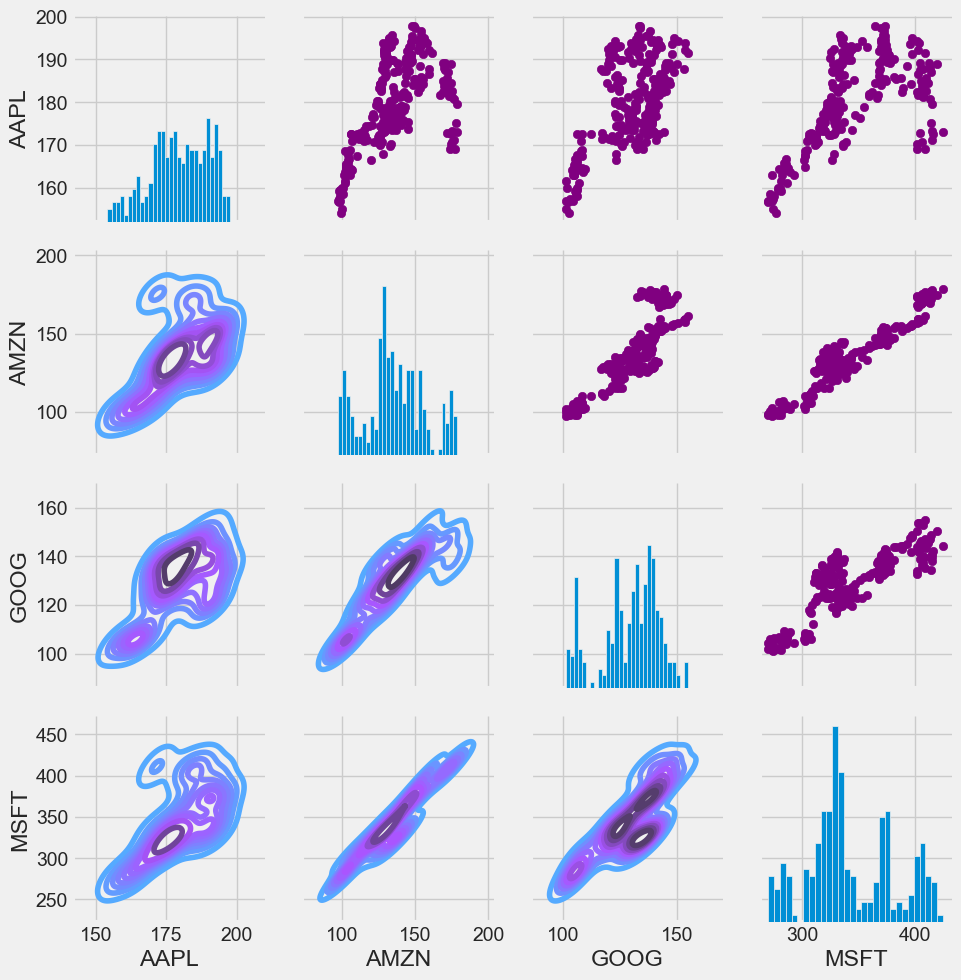

In [150]:
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

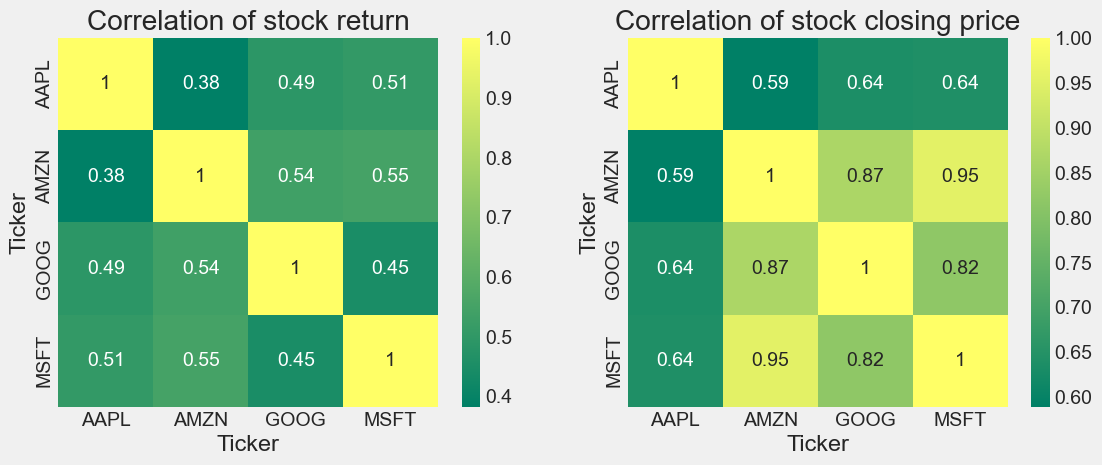

In [151]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

In [156]:
df_appl = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.datetime.now())
# Show teh data
df_appl

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433827,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500647,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639429,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771559,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400
...,...,...,...,...,...,...
2024-03-11,172.940002,174.380005,172.050003,172.750000,172.750000,60139500
2024-03-12,173.149994,174.029999,171.009995,173.229996,173.229996,59825400
2024-03-13,172.770004,173.190002,170.759995,171.130005,171.130005,52488700


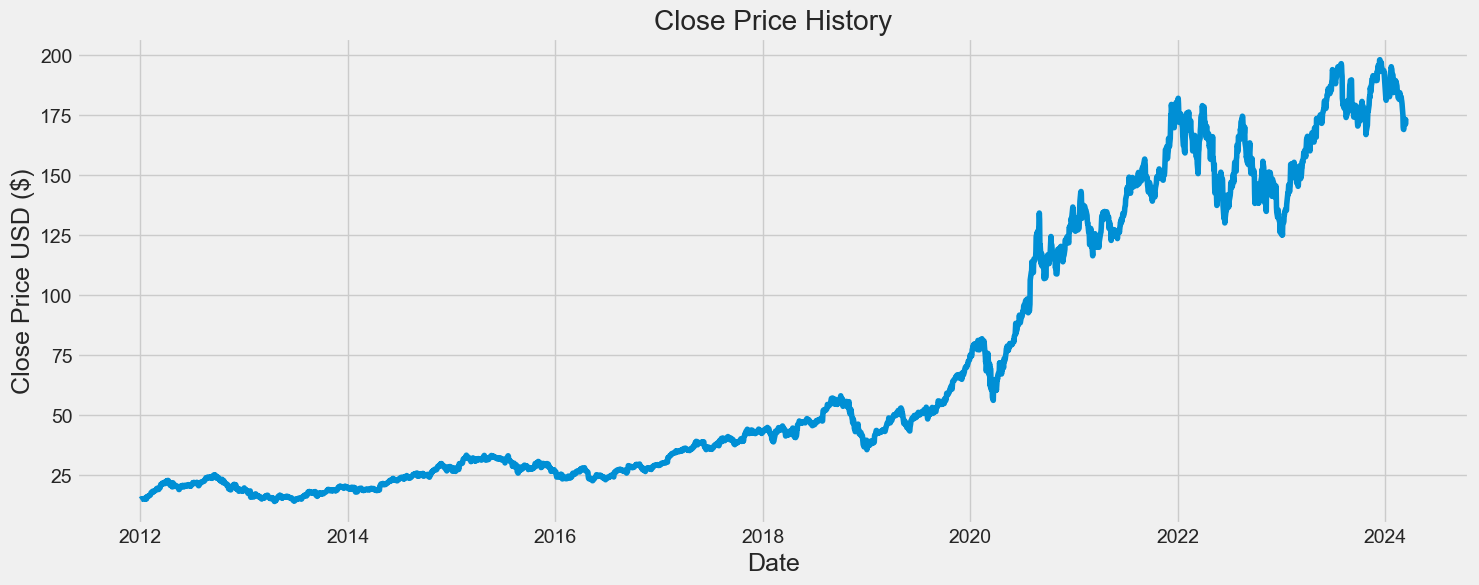

In [157]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_appl['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [187]:
df_appl_close = df_appl.Close

### Decomposition

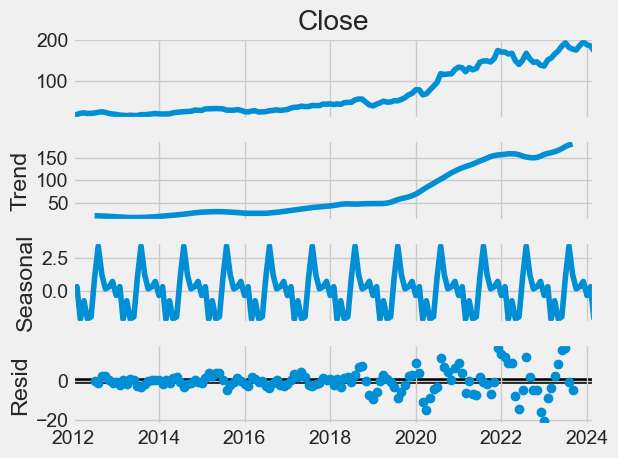

In [258]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_appl_close)
# Plot the original data, the trend, the seasonality, and the residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig=decomposition.plot()
plt.show()

### Checking for stationarity

In [197]:
kpss(df_appl_close, regression='c', nlags='auto', store=False)

(1.5080001307747628,
 0.01,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now less than 0.05, so we can reject the null hypothesis and our data is not stationary.

<Axes: xlabel='Date'>

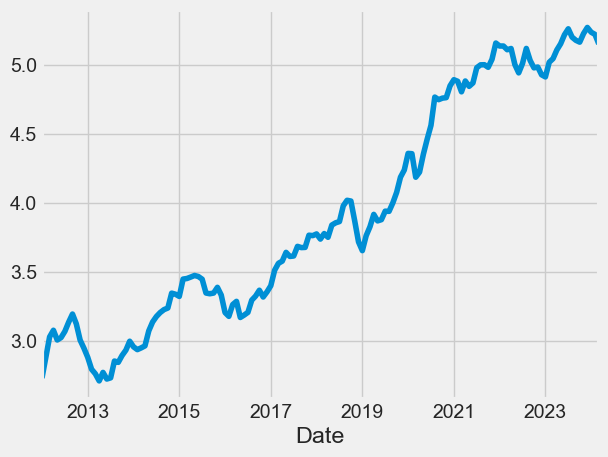

In [189]:
# Removing the variance from the data
df_appl_close_log = np.log(df_appl_close)
df_appl_close_log.plot()

<Axes: xlabel='Date'>

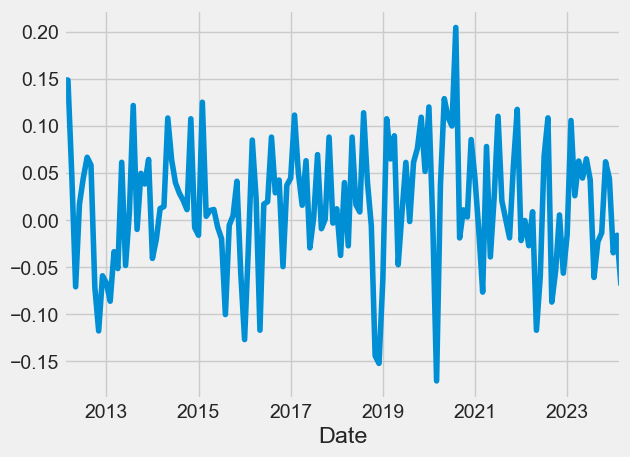

In [193]:
df_appl_close_log_diff = df_appl_close_log.diff().dropna()
df_appl_close_log_diff.plot()

In [199]:
kpss(df_appl_close_log_diff, regression='c', nlags='auto', store=False)

(0.06719611180734142,
 0.1,
 1,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### Sampling the data by month and take the mean

In [202]:
df_appl_monthly = df_appl.resample('MS').mean()

In [203]:
df_appl_close_month = df_appl_monthly.Close

In [204]:
df_appl_close_month.head()

Date
2012-01-01    15.306357
2012-02-01    17.770393
2012-03-01    20.625276
2012-04-01    21.642964
2012-05-01    20.166899
Freq: MS, Name: Close, dtype: float64

### Transforming data using natural log and finding the optimum values of p,d, and q

In [168]:
df_appl_close_month = np.log(df_appl_close_month)

In [200]:
import warnings
warnings.filterwarnings("ignore")
arima_params(df_appl_close_log_diff,3,3,3)

(0.003363353061635746, (1, 0, 2))

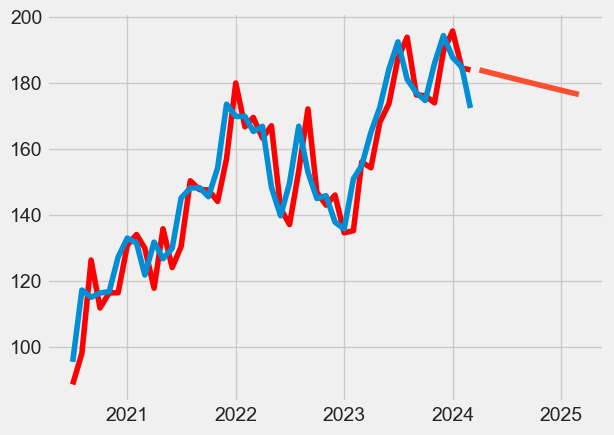

Test RMSE: 9.412


In [208]:
data_split = 0.7
p = 1
d = 0
q = 2
params = [p, d, q]
future_periods = 12
log = True

error, predictions, test, forecast1, future_dates1 = arima_model(df_appl_close_month, data_split, params, future_periods, log)

In [ ]:
plt.plot(future_dates1, forecast1)
plt.xticks(rotation=45)

### Considering all the data (not samples monthly data)

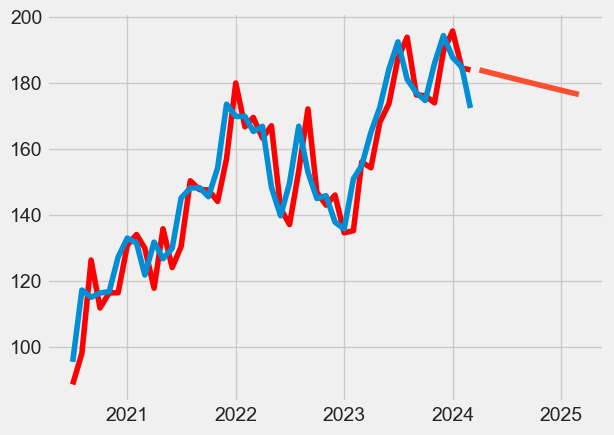

Test RMSE: 9.412


In [209]:
data_split = 0.7
p = 1
d = 0
q = 2
params = [p, d, q]
future_periods = 12
log = True

error, predictions, test, forecast2, future_dates2 = arima_model(df_appl_close, data_split, params, future_periods, log)

(array([19844., 19905., 19967., 20028., 20089., 20148.]),
 [Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03')])

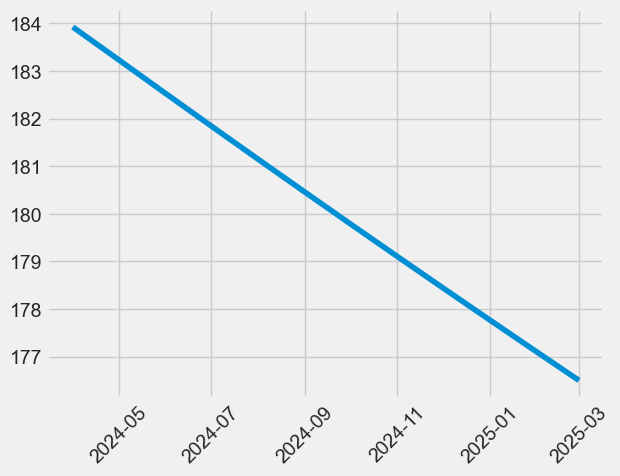

In [210]:
plt.plot(future_dates2, forecast2)
plt.xticks(rotation=45)

                 t-0       t-1
Date                          
2023-11-01  0.619998  0.419003
2023-12-01  0.572440  0.619998
2024-01-01  0.362551  0.572440
2024-02-01  0.412187  0.362551
2024-03-01  0.269831  0.412187
                 t-0       t-1
Date                          
2023-11-01  0.619998  0.419003
2023-12-01  0.572440  0.619998
2024-01-01  0.362551  0.572440
2024-02-01  0.412187  0.362551
2024-03-01  0.269831  0.412187
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


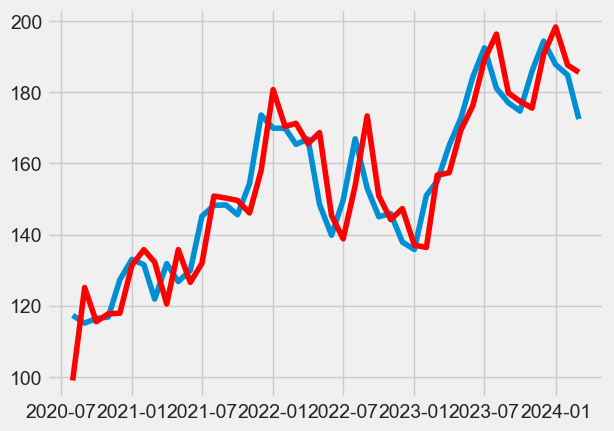

Train RMSE: 2.785
Test RMSE: 9.329


In [188]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

error, train_predict, y_train, test_predict, y_test, X_train_r, y_train_r, X_test_r, y_test_r, train_dates_r, test_dates_r, \
                                    scaler_r = lstm_model(df_appl_close, look_back, split, transforms, lstm_params)

The ARIMA model and LSTM method show similar RMSE values (very close).

# Example 2: S&P 500 historical data

Below shows the S&P 500 historical closing price data from 1950 through October 2017 (obtained through Yahoo Finance). The data is averaged monthly and plotted below. This trend shows increasing values over time, along with some steep increases and decreases. 

The ARIMA model performed slightly better than the LSTM model, but the improvements were mostly negligible.

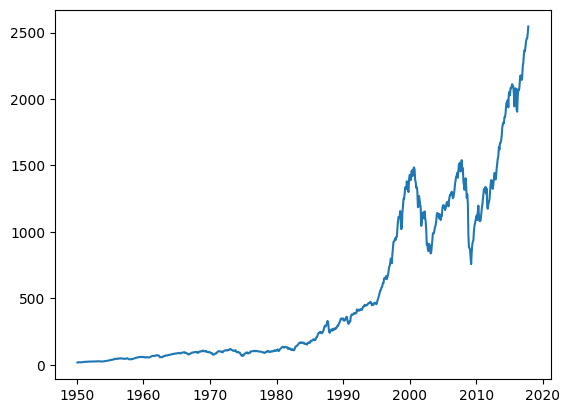

In [82]:
sp500 = pd.read_csv('sphist.csv', parse_dates=['Date'], index_col="Date")
sp500_monthly = sp500.resample('M').mean()
sp500_ts = sp500_monthly.Close
plt.plot(sp500_ts)

In [218]:
sp500_ts.shape

(814,)

In [83]:
sp500_ts.head()

Date
1950-01-31    16.875714
1950-02-28    17.192778
1950-03-31    17.346522
1950-04-30    17.845263
1950-05-31    18.434546
Freq: ME, Name: Close, dtype: float64

In [85]:
sp500_ts.index[-1]

Timestamp('2017-10-31 00:00:00')

### Checking for stationarity

In [212]:
kpss(sp500_ts, regression='c', nlags='auto', store=False)

(3.546565868727043,
 0.01,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now less than 0.05, so we can reject the null hypothesis and our data is not stationary.

<Axes: xlabel='Date'>

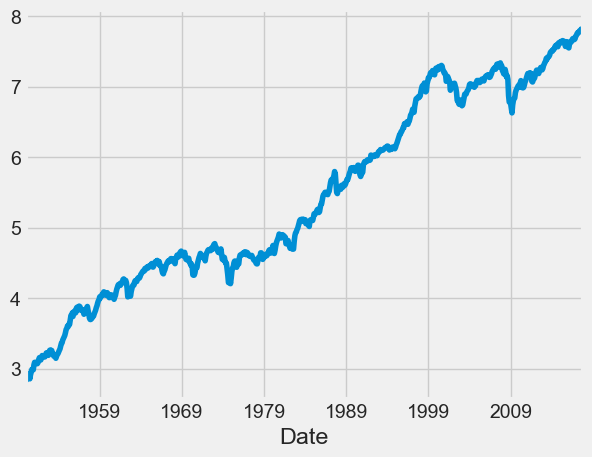

In [213]:
sp500_ts_log = np.log(sp500_ts)
sp500_ts_log.plot()

<Axes: xlabel='Date'>

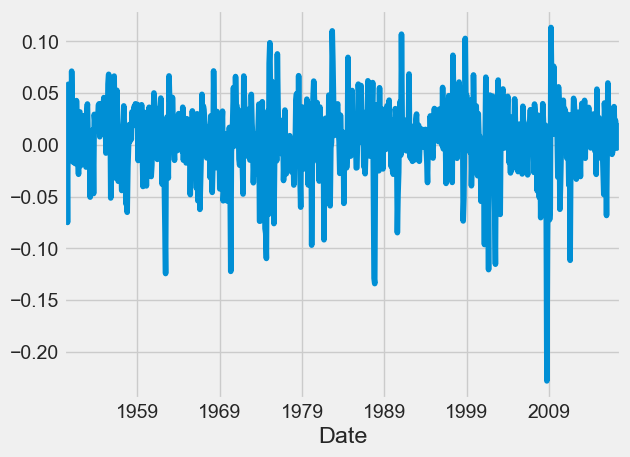

In [214]:
sp500_ts_log_diff = sp500_ts_log.diff().dropna()
sp500_ts_log_diff.plot()

In [215]:
kpss(sp500_ts_log_diff, regression='c', nlags='auto', store=False)

(0.0647687826314696,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis and our data is stationary.

### Decomposition

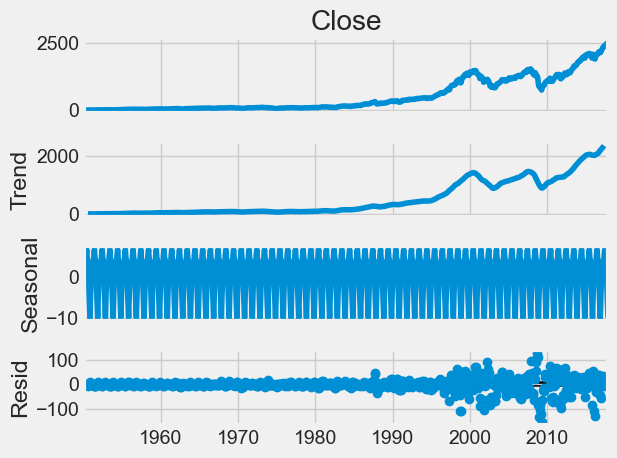

In [259]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sp500_ts)
# Plot the original data, the trend, the seasonality, and the residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig=decomposition.plot()
plt.show()

### S&P 500 ARIMA model

In [222]:
sp500_yearly = sp500.resample('Y').mean()
sp500_ts_y = sp500_yearly.Close

In [223]:
sp500_ts_y.shape

(68,)

In [228]:
sp500_ts_y_log = np.log(sp500_ts_y)
sp500_ts_y_log_diff = sp500_ts_y_log.diff().dropna()

In [230]:
warnings.filterwarnings("ignore")
arima_params(sp500_ts_y,3,3,3)

(24835.531248141266, (0, 2, 2))

In [225]:
# Now, we choose a couple of values to try for each parameter.
warnings.filterwarnings("ignore")
arima_params(sp500_ts_y_log,3,3,3)

(0.015856166911540886, (0, 2, 2))

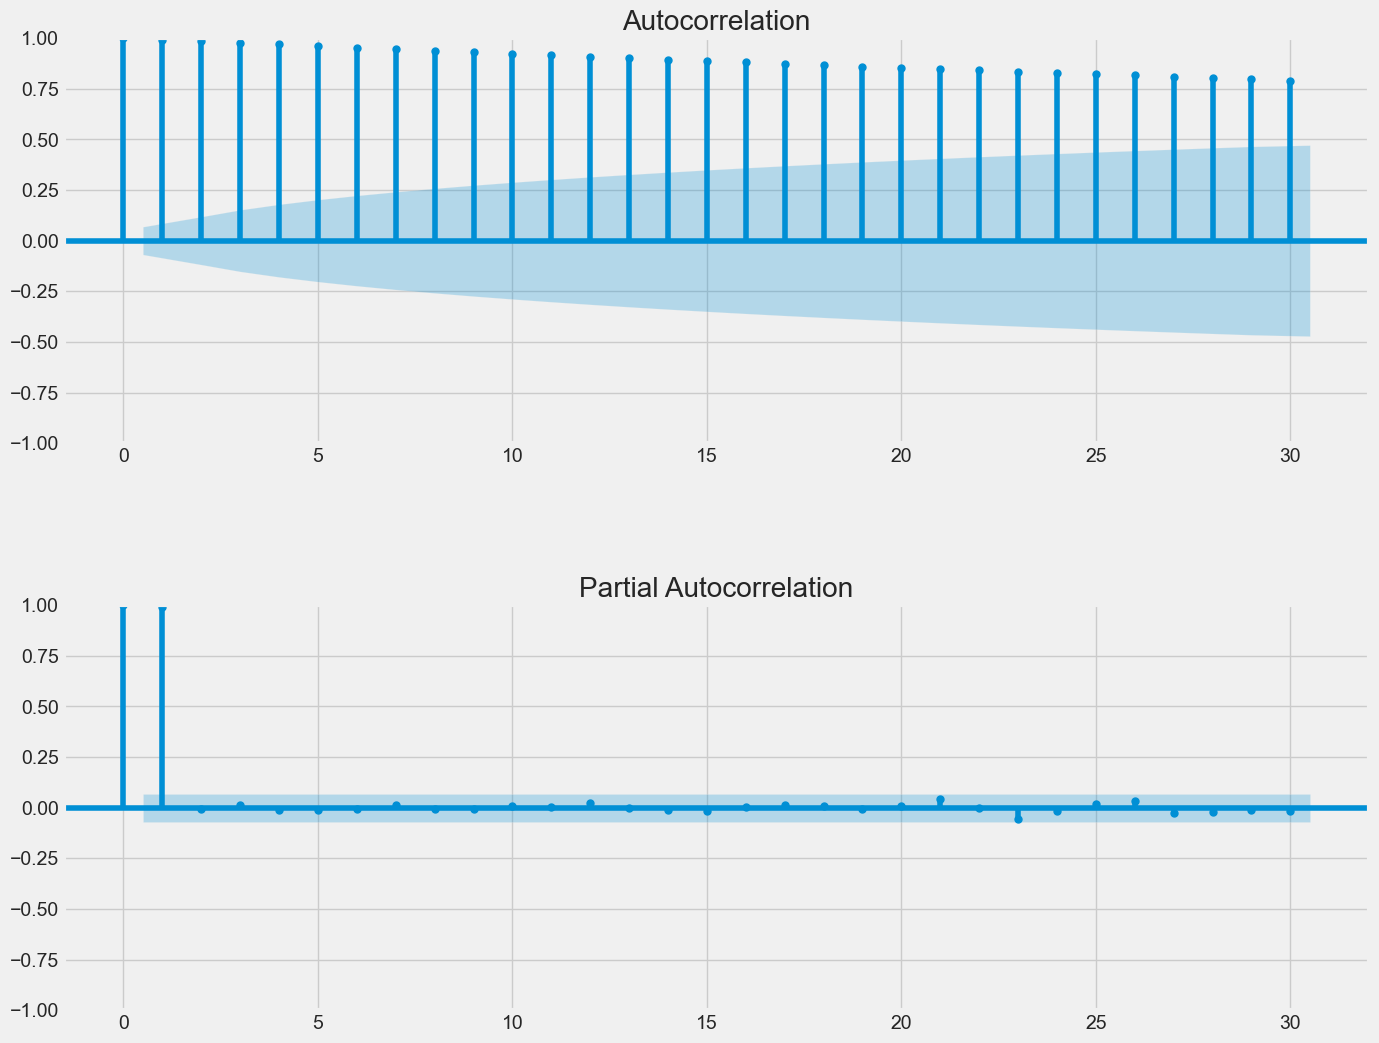

In [255]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs=plt.subplots(2,1, figsize=(15,12))
plt.subplots_adjust(hspace=0.4)
plot_acf(sp500_ts, ax=axs[0])
plot_pacf(sp500_ts, ax=axs[1])
plt.show()

In the following, we use the difference series. Th optimum values give a d of 0, which makes sense as we obtained that with one diferencing, the time series became stationary.

In [229]:
warnings.filterwarnings("ignore")
arima_params(sp500_ts_y_log_diff,3,3,3)

(0.013249686845528923, (2, 0, 2))

The ARIMA predictions below have an average RMSE value of 45.5 (with the range of actual values being from ~800 to 2500). One differencing period and log transformation was used.

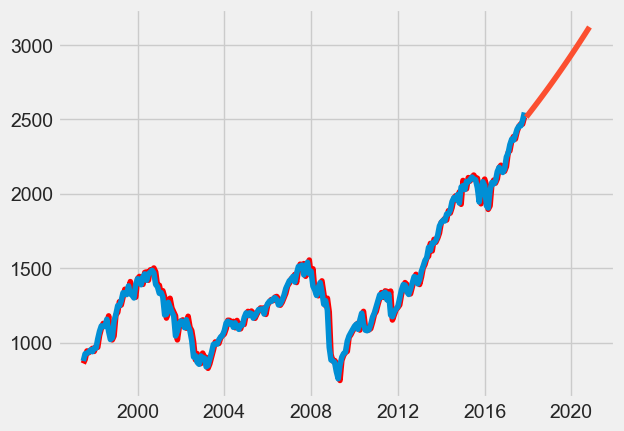

Test RMSE: 45.527


In [226]:
data_split = 0.7
p = 0
d = 2
q = 2
params = [p, d, q]
future_periods = 36
log = True

error, predictions, test, forecast3, future_dates3 = arima_model(sp500_ts, data_split, params, future_periods, log)

(array([17532., 17652., 17775., 17897., 18017., 18140., 18262., 18383.,
        18506.]),
 [Text(17532.0, 0, '2018-01'),
  Text(17652.0, 0, '2018-05'),
  Text(17775.0, 0, '2018-09'),
  Text(17897.0, 0, '2019-01'),
  Text(18017.0, 0, '2019-05'),
  Text(18140.0, 0, '2019-09'),
  Text(18262.0, 0, '2020-01'),
  Text(18383.0, 0, '2020-05'),
  Text(18506.0, 0, '2020-09')])

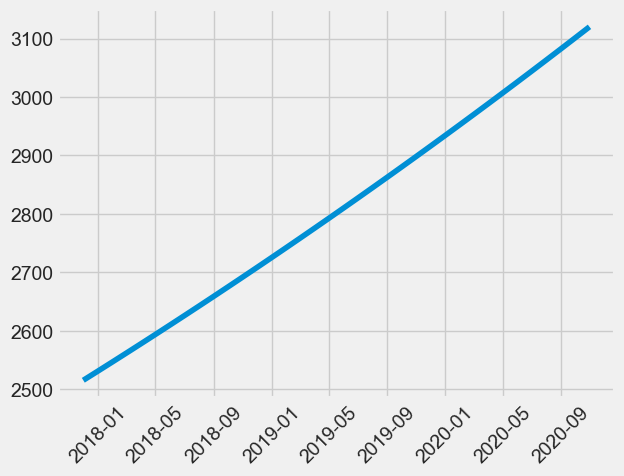

In [231]:
plt.plot(future_dates3, forecast3)
plt.xticks(rotation=45)

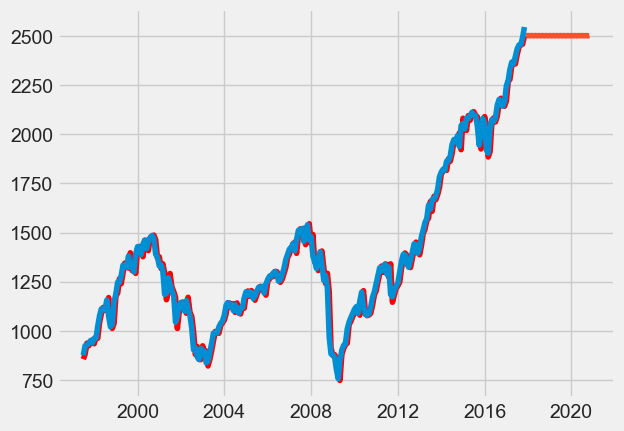

Test RMSE: 45.661


In [232]:
data_split = 0.7
p = 2
d = 0
q = 2
params = [p, d, q]
future_periods = 36
log = True

error, predictions, test, forecast4, future_dates4 = arima_model(sp500_ts, data_split, params, future_periods, log)

In [ ]:
plt.plot(future_dates4, forecast4)
plt.xticks(rotation=45)

The ARIMA model and LSTM methods show very similar RMSE values.

### S&P 500 LSTM model

In [ ]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

error, train_predict, y_train, test_predict, y_test, X_train_r, y_train_r, X_test_r, y_test_r, train_dates_r, test_dates_r, \
                                    scaler_r = lstm_model(sp500_ts, look_back, split, transforms, lstm_params)

### Example-3: CAC40 Stocks

CAC40, previously known as Bourse de Paris, is a benchmark French stock market index. The index represents a capitalization-weighted measure of the 40 most significant stocks among the 100 largest market caps on the Euronext Paris. Its acronym stands for Cotation Assistée en Continu, which translates to continuous assisted trading, and is used as a benchmark index for funds investing in the French stock market.

### Sourcing and loading

In [52]:
# Reading our dataset
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'], index_col='Date')
df.head()

,Unnamed: 0,Name,Open,Closing_Price,Daily_High,Daily_Low,Volume
Date,,,,,,,
2020-04-03,0,Accor,22.99,23.40,23.40,22.99,67
2020-04-02,1,Accor,23.91,22.99,23.91,22.99,250
2020-04-01,2,Accor,24.10,23.83,24.10,23.83,37
2020-03-31,3,Accor,25.04,25.00,25.24,24.99,336
2020-03-30,4,Accor,26.50,25.02,26.50,24.99,415


### Cleaning, transforming and visualizing

In [53]:
df.drop(columns=['Unnamed: 0'], inplace=True)

df.set_index('Date', inplace=True)

In [54]:
df.index.dtype

dtype('<M8[ns]')

In [55]:
df.head()

,Name,Open,Closing_Price,Daily_High,Daily_Low,Volume
Date,,,,,,
2020-04-03,Accor,22.99,23.40,23.40,22.99,67
2020-04-02,Accor,23.91,22.99,23.91,22.99,250
2020-04-01,Accor,24.10,23.83,24.10,23.83,37
2020-03-31,Accor,25.04,25.00,25.24,24.99,336
2020-03-30,Accor,26.50,25.02,26.50,24.99,415


In [56]:
df.dtypes

Name              object
Open             float64
Closing_Price    float64
Daily_High       float64
Daily_Low        float64
Volume            object
dtype: object

In [57]:
df['Volume'] = df.Volume.replace(',','', regex=True)

In [58]:
df.Volume = df.Volume.fillna(0)

In [59]:
df.Volume = df.Volume.astype('int')

In [60]:
df.shape

(97648, 6)

In [61]:
df.Name.unique()

array(['Accor', 'Air Liquide', 'Airbus ', 'ArcelorMittal', 'Atos', 'AXA',
       'BNP Paribas', 'Bouygues', 'Cap Gemini', 'Crédit Agricole',
       'Danone', 'Dassault Systèmes', 'Engie (ex GDF Suez',
       'EssilorLuxottica', 'Hermès (Hermes International', 'Kering',
       'LEGRAND', 'LOréal', 'LVMH Moet Hennessy Louis Vuitton',
       'Michelin (Compagnie Générale d Etablissements Michelin SCPA',
       'Orange', 'Pernod Ricard', 'Peugeot', 'Publicis', 'Renault',
       'SAFRAN', 'Saint-Gobain', 'Sanofi', 'Schneider Electric',
       'Société Générale (Societe Generale', 'Sodexo',
       'STMicroelectronics', 'TOTAL', 'Unibail-Rodamco',
       'Veolia Environnement', 'VINCI', 'Vivendi', 'Worldline SA'],
      dtype=object)

### Modelling

In [90]:
df_new = df[df['Name']=='TOTAL']
df_new = df_new.sort_values(by='Date')
df_new.drop(columns=['Name'], inplace=True)

In [96]:
df_monthly = df_new.resample('MS').mean()
df_new_month = df_monthly.Closing_Price

In [97]:
df_new_month

Date
2010-01-01    35.223500
2010-02-01    33.184500
2010-03-01    33.648261
2010-04-01    34.283500
2010-05-01    30.828571
                ...    
2019-12-01    48.143333
2020-01-01    48.360000
2020-02-01    43.990500
2020-03-01    31.126818
2020-04-01    34.703333
Freq: MS, Name: Closing_Price, Length: 124, dtype: float64

<Axes: xlabel='Date'>

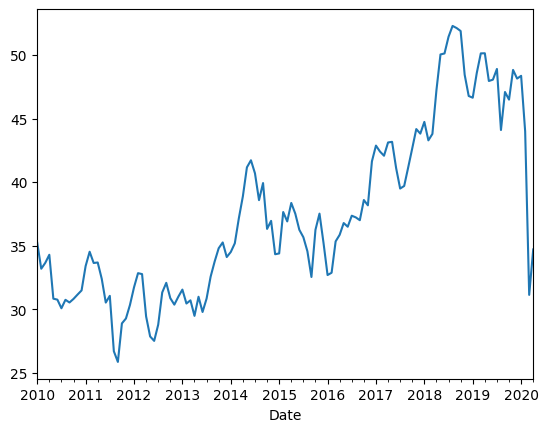

In [98]:
df_new_month.plot()

In [102]:
df_new_log = np.log(df_new_month)

In [103]:
df_new_log

Date
2010-01-01    3.561713
2010-02-01    3.502083
2010-03-01    3.515961
2010-04-01    3.534664
2010-05-01    3.428442
                ...   
2019-12-01    3.874183
2020-01-01    3.878673
2020-02-01    3.783974
2020-03-01    3.438070
2020-04-01    3.546836
Freq: MS, Name: Closing_Price, Length: 124, dtype: float64

### Decomposition

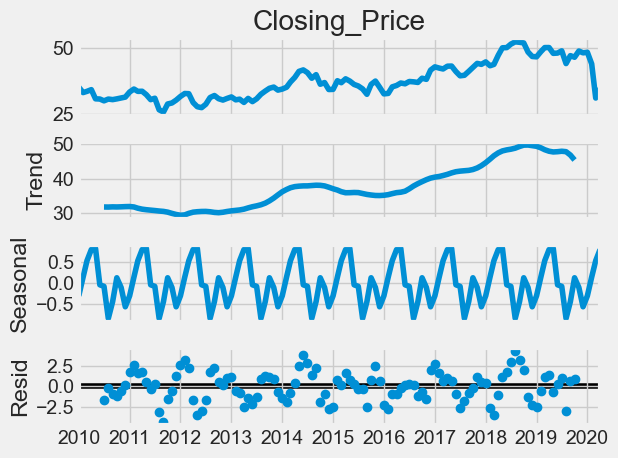

In [260]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_new_month)
# Plot the original data, the trend, the seasonality, and the residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig=decomposition.plot()
plt.show()

In [104]:
# Now, we choose a couple of values to try for each parameter.
warnings.filterwarnings("ignore")
arima_params(df_new_log,3,3,3)

(0.007066207145512423, (1, 0, 0))

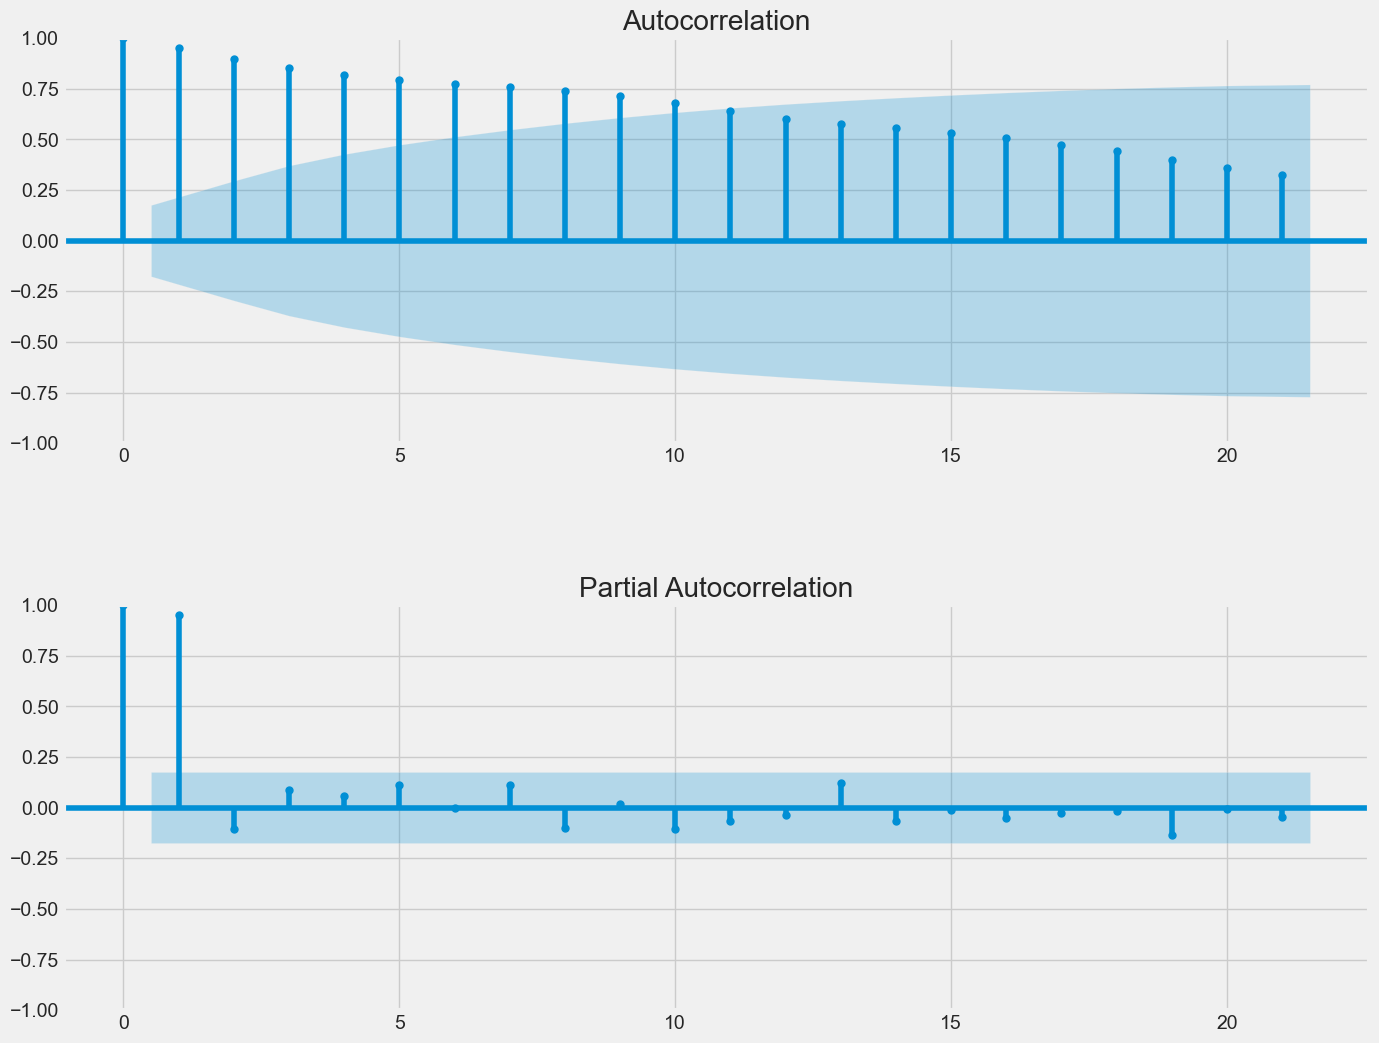

In [257]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axs=plt.subplots(2,1, figsize=(15,12))
plt.subplots_adjust(hspace=0.4)
plot_acf(df_new_month, ax=axs[0])
plot_pacf(df_new_month, ax=axs[1])
plt.show()

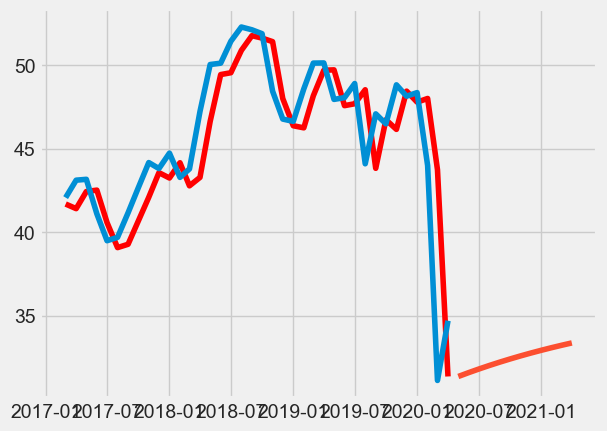

Test RMSE: 2.835


In [239]:
data_split = 0.7
p = 1
d = 0
q = 0
params = [p, d, q]
future_periods = 12
log = True

error, predictions, test, forecast5, future_dates5 = arima_model(df_new_month, data_split, params, future_periods, log)

(array([18383., 18444., 18506., 18567., 18628., 18687.]),
 [Text(18383.0, 0, '2020-05'),
  Text(18444.0, 0, '2020-07'),
  Text(18506.0, 0, '2020-09'),
  Text(18567.0, 0, '2020-11'),
  Text(18628.0, 0, '2021-01'),
  Text(18687.0, 0, '2021-03')])

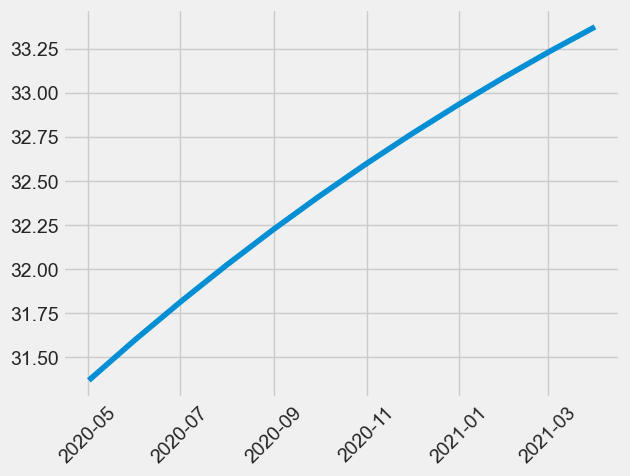

In [240]:
plt.plot(future_dates5, forecast5)
plt.xticks(rotation=45)

                 t-0       t-1
Date                          
2019-12-01  0.726598  0.864788
2020-01-01  0.767203  0.726598
2020-02-01  0.550023  0.767203
2020-03-01  0.000000  0.550023
2020-04-01  0.995519  0.000000
                 t-0       t-1
Date                          
2019-12-01  0.726598  0.864788
2020-01-01  0.767203  0.726598
2020-02-01  0.550023  0.767203
2020-03-01  0.000000  0.550023
2020-04-01  0.995519  0.000000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


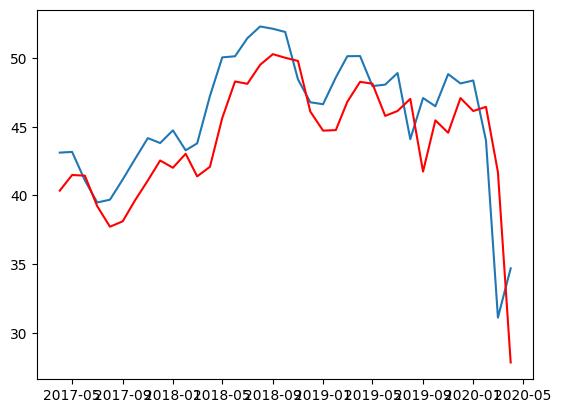

Train RMSE: 2.138
Test RMSE: 3.316


In [108]:
look_back = 1
split = 0.7
log = True
difference = True
transforms = [log, difference]

nodes = 4
epochs = 5
verbose = 0 # 0=print no output, 1=most, 2=less, 3=least
lstm_params = [nodes, epochs, verbose]

error, train_predict, y_train, test_predict, y_test, X_train_r, y_train_r, X_test_r, y_test_r, train_dates_r, test_dates_r, \
                                    scaler_r = lstm_model(df_new_month, look_back, split, transforms, lstm_params)

The ARIMA model slightly outweigh LSTM method with slightly lower values RMSE values.